## Final superresolution training

In [1]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.base import advection
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
import jax_cfd.ml.diego_preprocessing as preprocessing
import jax_cfd.ml.diego_train_functions as training
from jax_cfd.ml import nonlinearities
import jax_cfd.ml.diego_cnn_bcs as bcs

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

import matplotlib.pyplot as plt
import seaborn

import time

# import tree_math

In [2]:
# this allows me to reload a module without having to interrupt the kernel
import importlib
importlib.reload(preprocessing)
# importlib.reload(from jax_cfd.ml.diego_train_functions import *)
# importlib.reload(from jax_cfd.ml import nonlinearities)
# importlib.reload(from jax_cfd.ml.diego_cnn_bcs import *)

<module 'jax_cfd.ml.diego_preprocessing' from '/rds/general/user/dd519/home/FYP/forked_jax/jax-cfd/jax_cfd/ml/diego_preprocessing.py'>

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})


In [4]:
# # split by timestamps
# x_shape = len(data.x)
# y_shape = len(data.y)
# high_def = []
# for i in range(int(len(data.time))):
#     this_time_u = jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape)
#     this_time_v = jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
#     this_time = [this_time_u, this_time_v]
#     high_def.append(this_time)

In [5]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = jnp.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
    ])
    high_def.append(this_time)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 10
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 10
Training dataset shape: 
	(864, 256, 64, 2)


In [7]:
np.shape(high_def[0])

(256, 64, 2)

In [8]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4



%time low_def = preprocessing.downsampleHighDefVelsNumpy(high_def,factor)
#conv_scaled_high_def = convertListToDeviceArray(scaled_high_def)
#conv_scaled_low_def = convertListToDeviceArray(scaled_low_def)



X_train = low_def[:split]
Y_train = high_def[:split]

X_test = low_def[split:]
Y_test = high_def[split:]

print("\nShapes of all datasets")
training.printAllShapes(X_train,Y_train, X_test,Y_test)

CPU times: user 21.1 s, sys: 43.4 ms, total: 21.1 s
Wall time: 21.2 s

Shapes of all datasets
(691, 256, 64, 2)
(691, 256, 64, 2)
(173, 256, 64, 2)
(173, 256, 64, 2)


In [9]:
def ConvNet(x):
    cnn = mytowers.CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 16,
    "hidden_layers" : 3,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [10]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [11]:
instance = training.MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(40), #rng_key
                      input_channels=2,
                      epochs = 80,
                      printEvery=1,#epochs
                      learning_rates=training.staggeredLearningRate((60,0.1),(20,0.01),(30,0.001)), #iterated over batches
                      batch_size=len(X_train)+1, # number (e.g. len(X_train)//2+1) or len(X_train)+1
                      validateEvery=1,
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(691, 256, 64, 2)
(691, 256, 64, 2)
(173, 256, 64, 2)
(173, 256, 64, 2)



Start time: 16:41:44
Epoch 1/80
	mse : 0.085552		val mse : 0.054196	Estimated end time: 17:09:58


Epoch 2/80
	mse : 0.053749		val mse : 0.043899	Estimated end time: 17:14:51


Epoch 3/80
	mse : 0.043478		val mse : 0.038610	Estimated end time: 17:16:40


Epoch 4/80
	mse : 0.038211		val mse : 0.035092	Estimated end time: 17:17:55


Epoch 5/80
	mse : 0.034716		val mse : 0.032529	Estimated end time: 17:18:24


Epoch 6/80
	mse : 0.032175		val mse : 0.030492	Estimated end time: 17:18:39


Epoch 7/80
	mse : 0.030157		val mse : 0.028776	Estimated end time: 17:18:52


Epoch 8/80
	mse : 0.028458		val mse : 0.027274	Estimated end time: 17:19:01


Epoch 9/80
	mse : 0.026970		val mse : 0.025924	Estimated end time: 17:19:08


Epoch 10/80
	mse : 0.025633		val mse : 0.024688	Estimated end time: 17:19:23


Epoch 11/80
	mse : 0.024409		val mse : 0.023543	Estimated end time: 17:19:30


Epoch 12/80
	mse : 0.

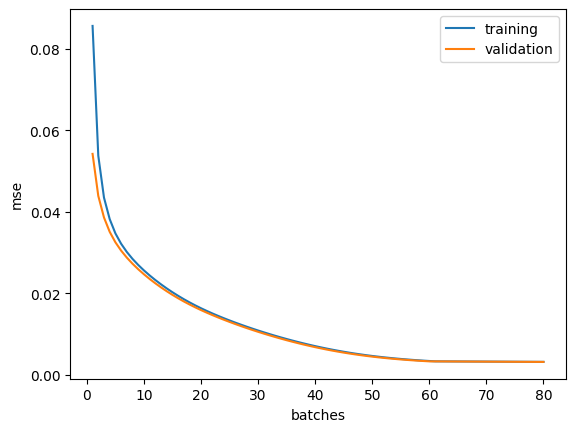

In [12]:

batches = np.arange(len(instance.losses))
val_step = len(instance.losses)//len(instance.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,instance.losses, label="training")
plt.plot(batches_val,instance.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [13]:
description = "5h16' training, wall time 39 minutes"

In [14]:
toSave = saving.newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [17]:
save_path = "./../models/final_models/superresolution_BICUBIC_direct2.pickle"

In [16]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

del save_path

## Loading model

In [18]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [19]:
loaded.description

"5h16' training, wall time 39 minutes"

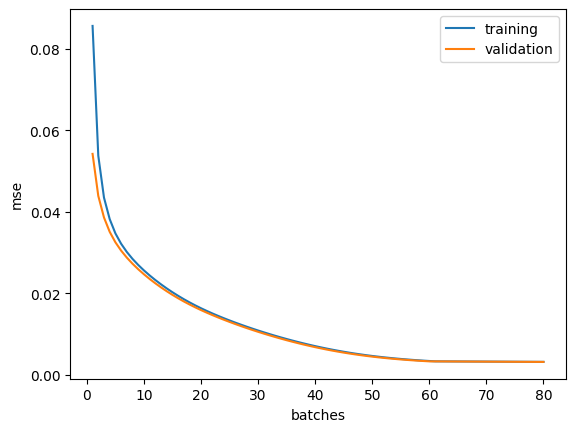

In [20]:
batches = np.arange(len(loaded.losses))
val_step = len(loaded.losses)//len(loaded.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,loaded.losses, label="training")
plt.plot(batches_val,loaded.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

## Predicting with model

In [21]:
num =  11 #int(np.random.rand()*np.shape(X_test)[0]//1)
vel = 0      # 0 is u, 1 is v

pred = loaded.forward_pass.apply(loaded.params,X_test[num])

In [22]:
def vorticity(u,v):
    #dvdx - dudy
    return np.gradient(v,axis = 0) -np.gradient(u,axis = 1)

In [23]:
np.shape(pred)

(256, 64, 2)

In [24]:
pred = loaded.forward_pass.apply(loaded.params,X_test[num])
np.shape(pred)

upred = pred[:,:,0]
vpred = pred[:,:,1]
vortpred = vorticity(upred,vpred)

uX = X_test[num][:,:,0]
vX = X_test[num][:,:,1]
vortX = vorticity(uX,vX)

uY = Y_test[num][:,:,0]
vY = Y_test[num][:,:,1]
vortY = vorticity(uY,vY)


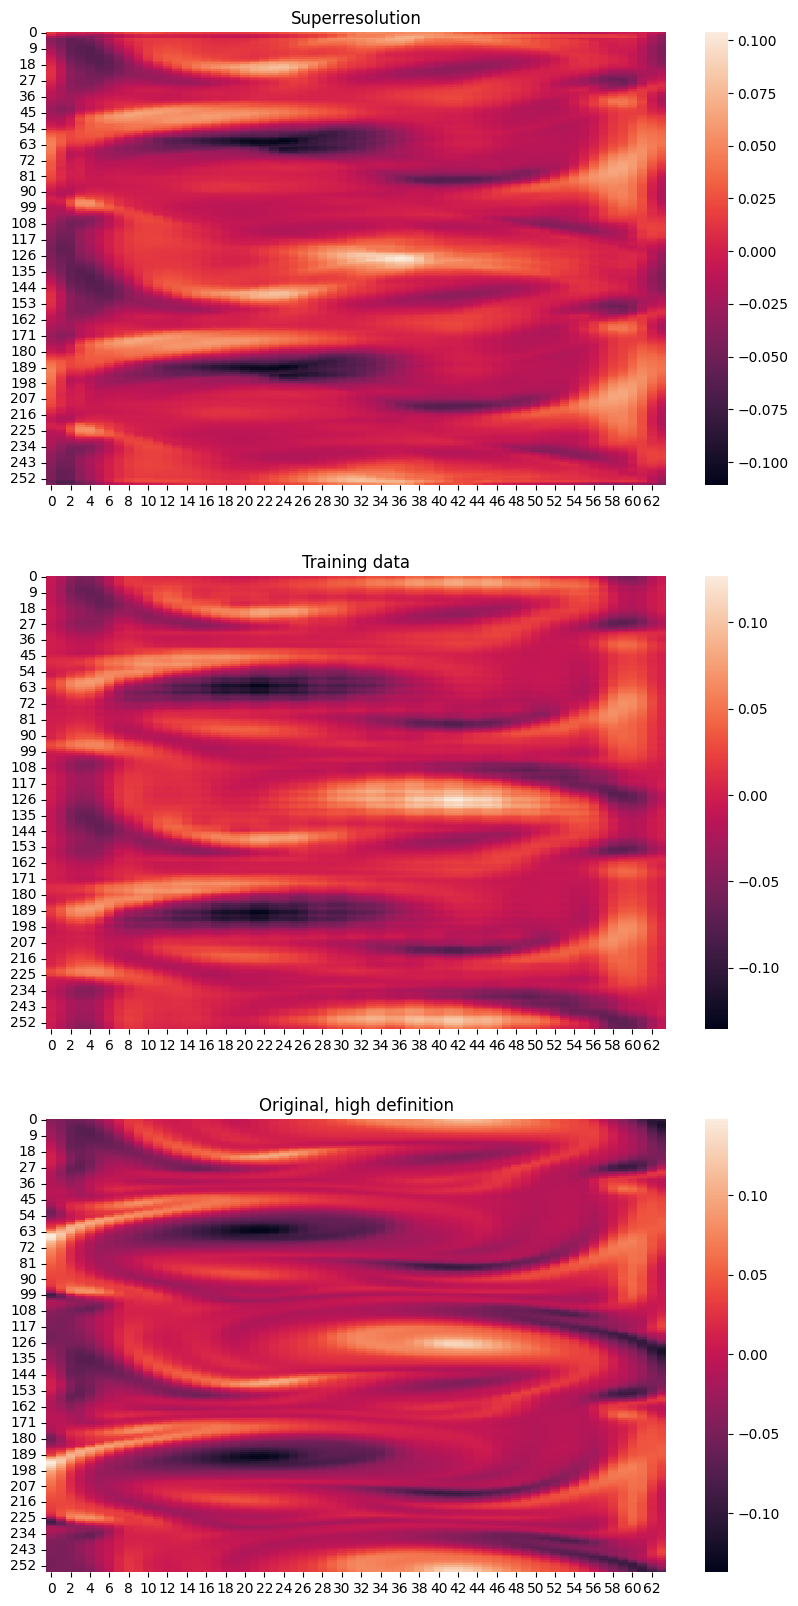

In [25]:
fig, axs = plt.subplots(3,1, facecolor='w', edgecolor='k',figsize=(10,20))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(vortpred,ax = axs[0])
axs[0].title.set_text("Superresolution")
im = seaborn.heatmap(vortX,ax = axs[1])
axs[1].title.set_text("Training data")
im = seaborn.heatmap(vortY,ax = axs[2])
axs[2].title.set_text("Original, high definition")

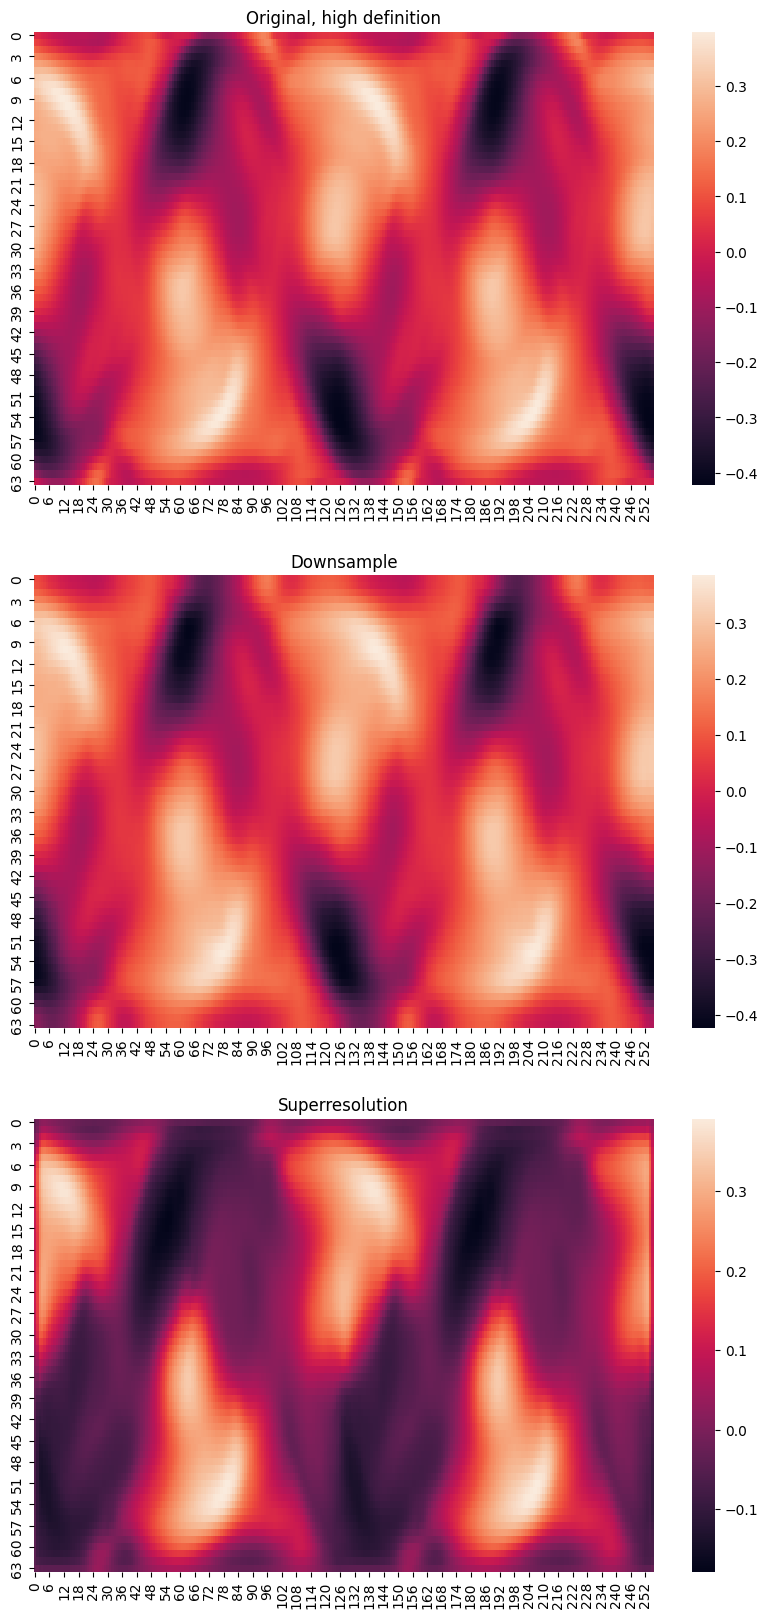

In [26]:
fig, axs = plt.subplots(3,1, facecolor='w', edgecolor='k',figsize=(10,20))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num][:,:,vel].T,ax = axs[0])
axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(X_test[num][:,:,vel].T,ax = axs[1])
axs[1].title.set_text("Downsample")
im = seaborn.heatmap(pred[:,:,vel].T,ax = axs[2])
axs[2].title.set_text("Superresolution")

In [27]:
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= float(target_data.shape[0] * target_data.shape[1])
    return err

In [28]:
err_before = mse(X_test[num][:,:,vel],Y_test[num][:,:,vel])
err_after = mse(pred[:,:,vel],Y_test[num][:,:,vel])

print("Error before correction: " + str(err_before))
print("Error after correction: " + str(err_after))

if err_after<err_before:
    print("Error reduced by network, nice")
else:
    print("WARNING: error increased by network")

Error before correction: 0.00015966542
Error after correction: 0.0063122185


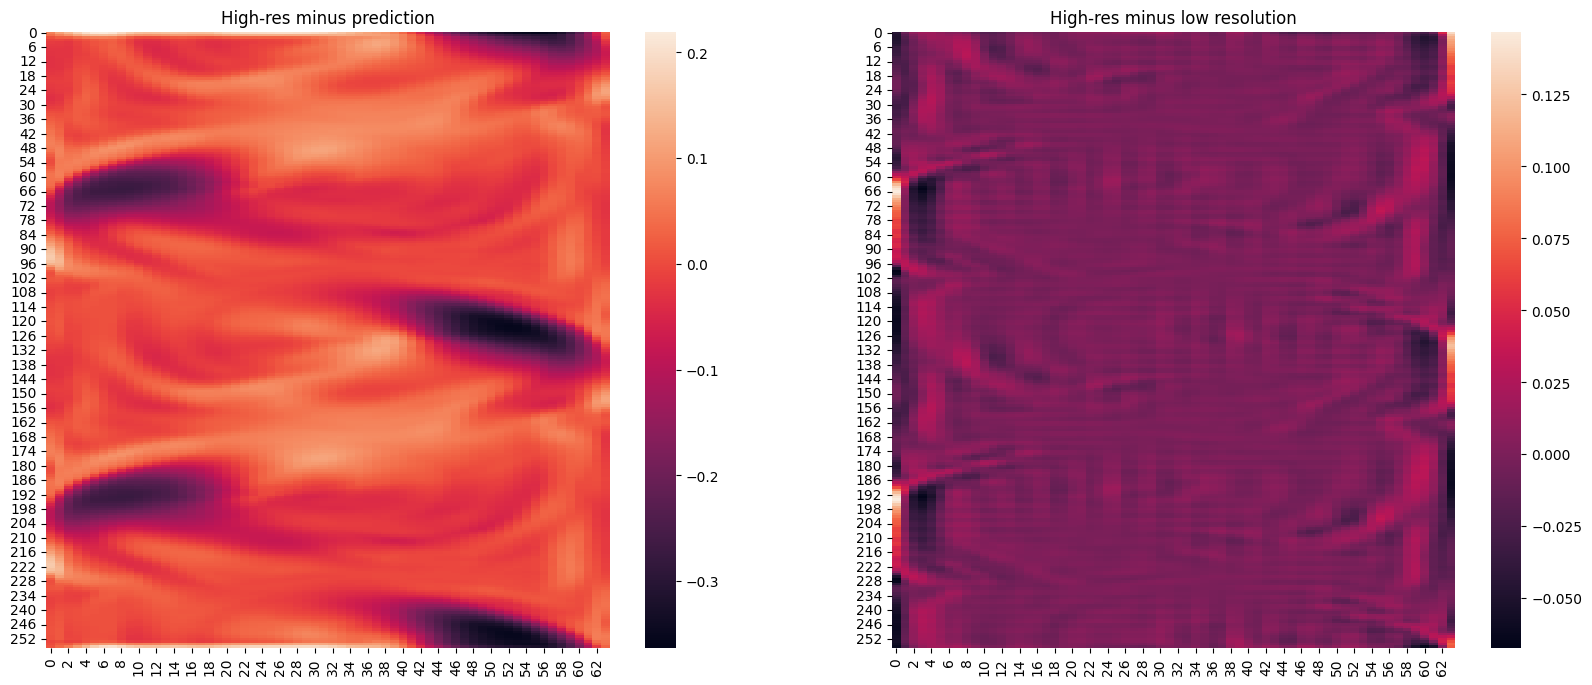

In [29]:
# I think these are called residuals (?)
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num][:,:,vel]-pred[:,:,vel],ax = axs[0])
axs[0].title.set_text("High-res minus prediction")
im = seaborn.heatmap(Y_test[num][:,:,vel]-X_test[num][:,:,vel],ax = axs[1])
axs[1].title.set_text("High-res minus low resolution")

In [30]:
print(mse(pred[:,:,0],pred[:,:,1]))
print(mse(Y_test[num][:,:,0],Y_test[num][:,:,1]))

0.054219227
0.058909785


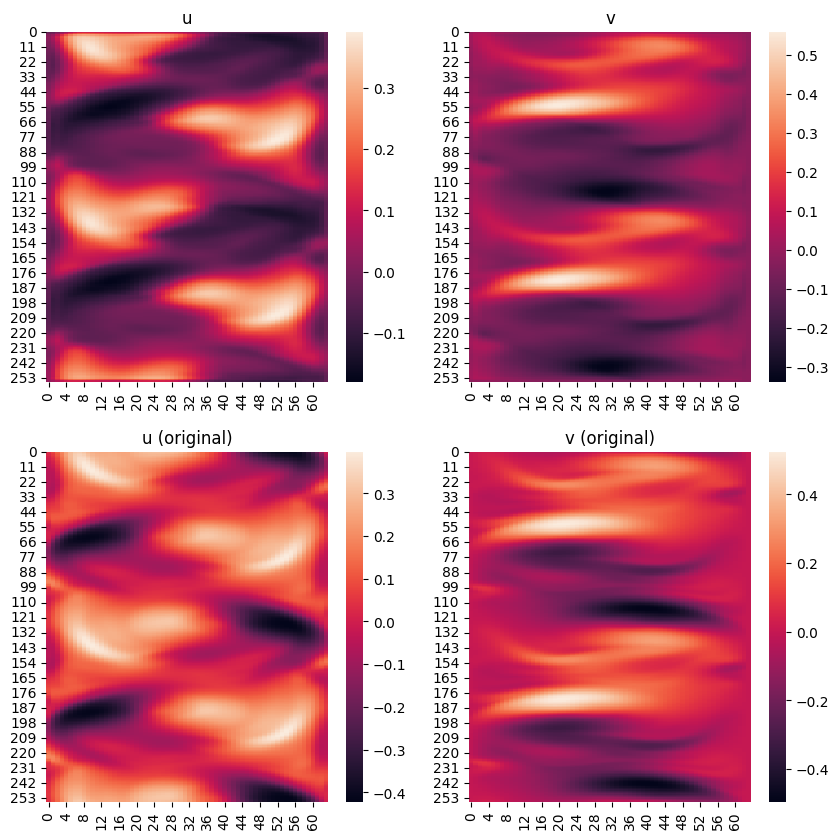

In [31]:
fig, axs = plt.subplots(2,2, facecolor='w', edgecolor='k',figsize=(10,10))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(pred[:,:,0],ax = axs[0])
axs[0].title.set_text("u")
im = seaborn.heatmap(pred[:,:,1],ax = axs[1])
axs[1].title.set_text("v")

im = seaborn.heatmap(Y_test[num][:,:,0],ax = axs[2])
axs[2].title.set_text("u (original)")
im = seaborn.heatmap(Y_test[num][:,:,1],ax = axs[3])
axs[3].title.set_text("v (original)")

0.03907942
0.04111195


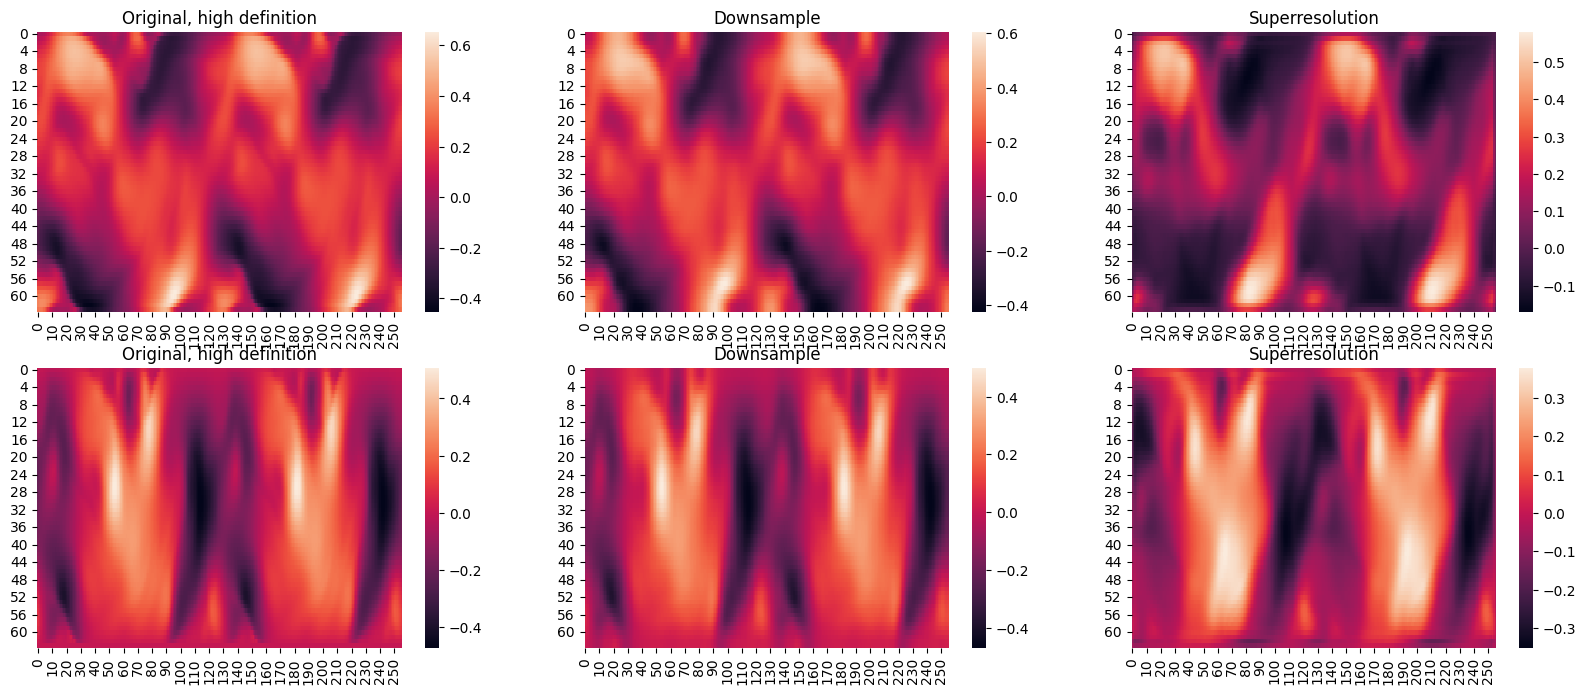

In [32]:
val = -1
X_u_train = X_train[val][:,:,0]
X_v_train = X_train[val][:,:,1]

Y_u_train = Y_train[val][:,:,0]
Y_v_train = Y_train[val][:,:,1]

testX = jnp.dstack([X_u_train,X_v_train])
testY = jnp.dstack([Y_v_train,Y_v_train])

testPred = loaded.forward_pass.apply(loaded.params,X_train[val])

print(jnp.power(jnp.array(testPred) - jnp.array(testY), 2).mean())

print(jnp.power(jnp.array(testX) - jnp.array(testY), 2).mean())

fig, axs = plt.subplots(2,3, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()
vel = 0
im = seaborn.heatmap(Y_train[num][:,:,vel].T,ax = axs[0])
axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(X_train[num][:,:,vel].T,ax = axs[1])
axs[1].title.set_text("Downsample")
im = seaborn.heatmap(testPred[:,:,vel].T,ax = axs[2])
axs[2].title.set_text("Superresolution")

vel = 1
im = seaborn.heatmap(Y_train[num][:,:,vel].T,ax = axs[3])
axs[3].title.set_text("Original, high definition")
im = seaborn.heatmap(X_train[num][:,:,vel].T,ax = axs[4])
axs[4].title.set_text("Downsample")
im = seaborn.heatmap(testPred[:,:,vel].T,ax = axs[5])
axs[5].title.set_text("Superresolution")